In [2]:
import pandas as pd

In [3]:
# Dataset Overview
# Load training data
df = pd.read_csv("../data/train.csv")

print("Shape of dataset:", df.shape)
print("\nColumns:")
print(df.columns)

print("\nFirst 5 rows:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

Shape of dataset: (421570, 5)

Columns:
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='str')

First 5 rows:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Missing values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [4]:
# Date Analysis
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

print("\nDate range:")
print("Start:", df['Date'].min())
print("End:", df['Date'].max())

# Data Structure Understanding
print("\nNumber of unique stores:", df['Store'].nunique())
print("Number of unique departments:", df['Dept'].nunique())



Date range:
Start: 2010-02-05 00:00:00
End: 2012-10-26 00:00:00

Number of unique stores: 45
Number of unique departments: 81


In [5]:
# Filtering for Initial Analysis
# Filter for Store 1 and Department 1
df_filtered = df[(df['Store'] == 1) & (df['Dept'] == 1)]

print("Filtered shape:", df_filtered.shape)
df_filtered.head()


Filtered shape: (143, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


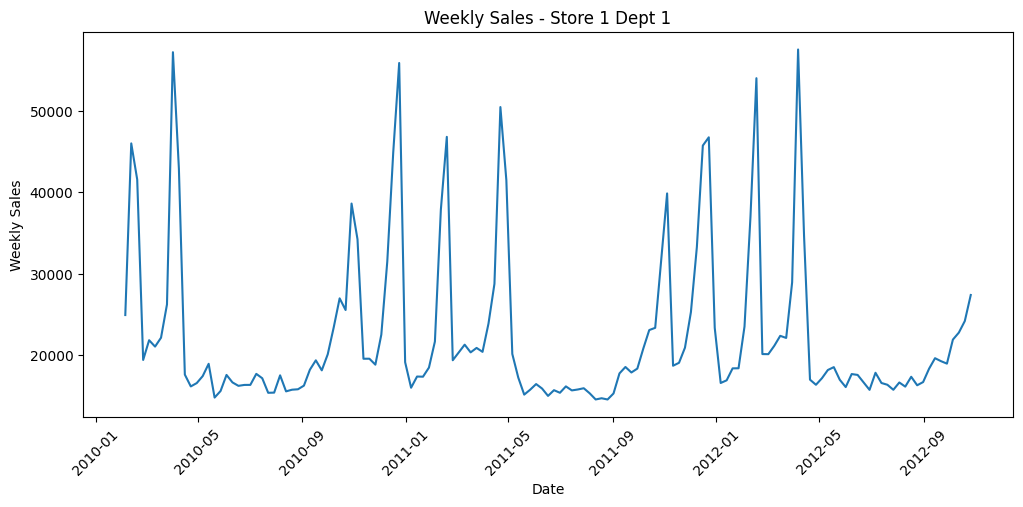

In [6]:
import matplotlib.pyplot as plt

#EDA Visualization Insights
# Sort by date (very important)
df_filtered = df_filtered.sort_values('Date')

plt.figure(figsize=(12,5))
plt.plot(df_filtered['Date'], df_filtered['Weekly_Sales'])
plt.title("Weekly Sales - Store 1 Dept 1")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.show()


In [7]:
# holiday impact check
holiday_sales = df_filtered[df_filtered['IsHoliday'] == True]

print(holiday_sales[['Date', 'Weekly_Sales']])


          Date  Weekly_Sales
1   2010-02-12      46039.49
31  2010-09-10      18194.74
42  2010-11-26      18820.29
47  2010-12-31      19124.58
53  2011-02-11      37887.17
83  2011-09-09      17746.68
94  2011-11-25      20911.25
99  2011-12-30      23350.88
105 2012-02-10      36988.49
135 2012-09-07      18322.37


In [8]:
# train-test split 
# why - in time series forcasting: we must simulate real life. 
# we train on past data and test on future data. we cannot shuffle

# Ensure sorted
df_filtered = df_filtered.sort_values('Date')

# 80% train, 20% test split
train_size = int(len(df_filtered) * 0.8)

train = df_filtered.iloc[:train_size]
test = df_filtered.iloc[train_size:]

print("Train size:", train.shape)
print("Test size:", test.shape)

# what this does? - first 80% = historical data (train), last 20$ = future data (test) 
# now we are mimicking real forecasting

Train size: (114, 5)
Test size: (29, 5)


In [9]:
# build Naive Baseline Model
# why - before building complex models, we must ask: "if i just predict last week's sales, how good is that?"
# if our model can't beat this simple baseline, then we have a problem.
# baseline is mandatory

# Naive forecast: next week = last week
test['Naive_Prediction'] = test['Weekly_Sales'].shift(1)

# Drop first row with NaN
test = test.dropna()


In [10]:
# calculate RMSE
# why - we need a number to measure performance.
# RMSE tells us howfar predictions are from actual values
# lower RMSE = better model

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], test['Naive_Prediction']))

print("Naive Model RMSE:", rmse)


Naive Model RMSE: 3584.771553442622


In [11]:
# is 3584 good or bad? to answer that, we compare it to average sales

print("Average Weekly Sales:", df_filtered['Weekly_Sales'].mean())


Average Weekly Sales: 22513.322937062938


In [12]:
# Average weekly sales ≈ 22,513
# Naive RMSE ≈ 3,585

# Let’s calculate rough percentage error mentally:

# 3585 / 22513 ≈ 0.159 → about 16%

# That means:

# Our naive model is off by about 16% on average.

# That is not bad.
# But it is not strong either.

# And that’s exactly what we want.

In [13]:
# 🧠 What This Tells Me:

# 1️⃣ The series has some predictability
# 2️⃣ Simply using last week’s value gives reasonable performance
# 3️⃣ But seasonality and spikes are not captured properly

# So now our job is:

# Build a model that beats 3585 RMSE.

# That’s our first milestone.

In [14]:
# Feature Engineering
# now we create features that allow the model to learn patterns better than naive

# Create lag features
df_filtered['Lag_1'] = df_filtered['Weekly_Sales'].shift(1) # Sales from previous week
df_filtered['Lag_2'] = df_filtered['Weekly_Sales'].shift(2) # Sales from 2 weeks ago
df_filtered['Lag_4'] = df_filtered['Weekly_Sales'].shift(4) # Sales from 4 weeks ago (1 month)
df_filtered['Lag_12'] = df_filtered['Weekly_Sales'].shift(12) # Sales from 12 weeks ago (seasonal memory)

# Rolling mean
df_filtered['Rolling_Mean_4'] = df_filtered['Weekly_Sales'].rolling(window=4).mean()

# Extract time-based features
df_filtered['Month'] = df_filtered['Date'].dt.month
df_filtered['Week'] = df_filtered['Date'].dt.isocalendar().week

# Drop missing rows created by shifting
df_filtered = df_filtered.dropna()

df_filtered.head()


# why - lag features capture short term memory, lag_12 capture seasonal patterns,
# rolling mean smooths noise, month/week encode seasonality numerically
# now we are giving the model more intelligence than naive

,Store,Dept,Date,Weekly_Sales,IsHoliday,Lag_1,Lag_2,Lag_4,Lag_12,Rolling_Mean_4,Month,Week
12,1,1,2010-04-30,16555.11,False,16145.35,17596.96,57258.43,24924.50,23314.5825,4,17
13,1,1,2010-05-07,17413.94,False,16555.11,16145.35,42960.91,46039.49,16927.8400,5,18
14,1,1,2010-05-14,18926.74,False,17413.94,16555.11,17596.96,41595.55,17260.2850,5,19
15,1,1,2010-05-21,14773.04,False,18926.74,17413.94,16145.35,19403.54,16917.2075,5,20
16,1,1,2010-05-28,15580.43,False,14773.04,18926.74,16555.11,21827.90,16673.5375,5,21


In [15]:
# re-train-test split after feature engineering

train_size = int(len(df_filtered) * 0.8)

train = df_filtered.iloc[:train_size]
test = df_filtered.iloc[train_size:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (104, 12)
Test size: (27, 12)


In [16]:
# define features and target

features = ['Lag_1', 'Lag_2', 'Lag_4', 'Lag_12', 
            'Rolling_Mean_4', 'Month', 'Week']

X_train = train[features]
y_train = train['Weekly_Sales']

X_test = test[features]
y_test = test['Weekly_Sales']


In [17]:
# train linear regression

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)


In [18]:
# evaluate RMSE

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_lr = np.sqrt(mean_squared_error(y_test, predictions))

print("Linear Regression RMSE:", rmse_lr)



Linear Regression RMSE: 3036.9347593727525


In [19]:
# 📊 Results Comparison

# Naive RMSE → 3584.77
# Linear Regression RMSE → 3036.93

# Improvement ≈ 548

# That’s about 15% improvement over naive.

# That is meaningful.

In [20]:
# 🧠 What This Means

# Our feature engineering worked.

# The model is:

# Using lag memory

# Using seasonal signals

# Using rolling average

# Using month/week information

# And it is capturing patterns better than “just last week”.

# That is real modeling progress.

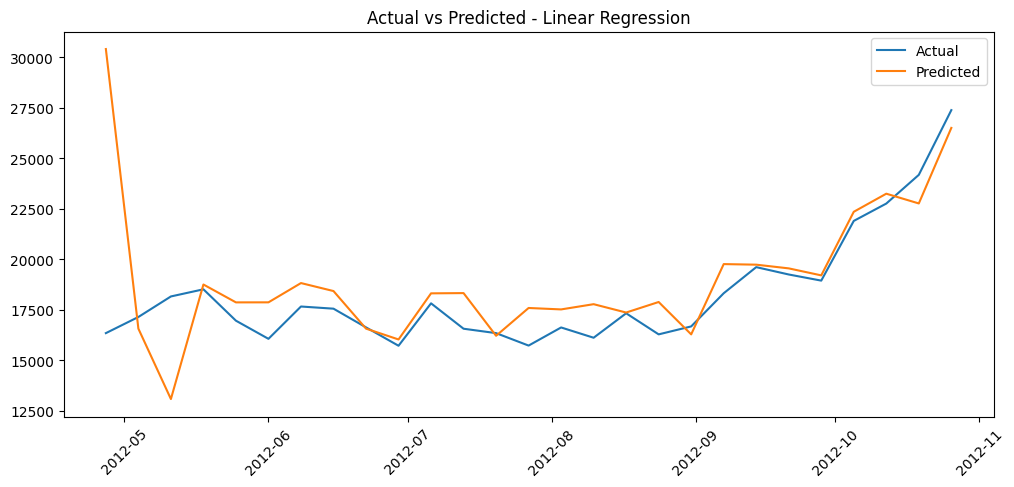

In [21]:
# Let’s visualize performance.

plt.figure(figsize=(12,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], predictions, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted - Linear Regression")
plt.xticks(rotation=45)
plt.show()


In [22]:
# 📊 What the Plot Shows:


# 1️⃣ Overall Pattern Capture — GOOD

# The predicted line closely follows the actual line.

# That means:

# Lag features are working.

# Model understands local trend.

# Short-term fluctuations are captured reasonably well.


# 2️⃣ Major Spikes — Slight Underperformance

# At the very beginning of the test set:

# There’s a large spike the model overestimated.

# This tells us:

# Linear regression struggles with extreme events.

# This is expected.

# Linear models are not great at nonlinear spike behavior.


# 3️⃣ Gradual Upward Movement — Captured

# Towards the end (October):

# Sales increase gradually.

# Model follows that pattern fairly well.

# That’s good seasonal capture.

In [23]:
# 🎯 What This Means Technically

# Our model:

# ✔ Captures seasonality partially
# ✔ Captures short-term dependencies
# ✔ Improves over naive baseline
# ✖ Struggles with extreme spikes

# That’s completely normal for linear regression.

In [24]:
# 🧠 Important Insight

# This is exactly why:

# Random Forest

# XGBoost

# often outperform linear regression in retail forecasting.

# Because they handle nonlinear patterns better.

In [25]:
# 🔥 Now We Upgrade

# Next logical step:

# Try Random Forest, because:

# It handles nonlinearities

# It captures complex lag interactions

# It often improves spike prediction

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest RMSE:", rmse_rf)


Random Forest RMSE: 1336.1294468431738


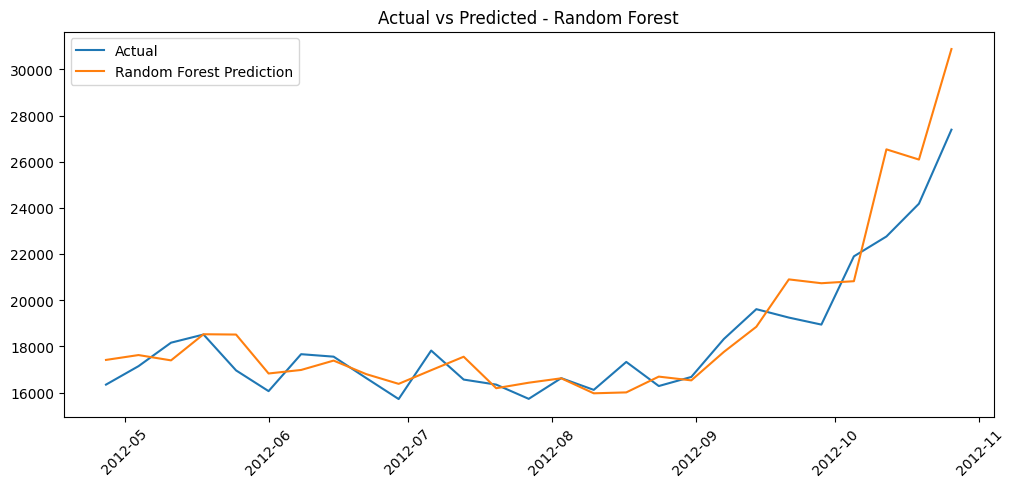

In [27]:
# Random Forest: Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], rf_predictions, label='Random Forest Prediction')
plt.legend()
plt.title("Actual vs Predicted - Random Forest")
plt.xticks(rotation=45)
plt.show()

In [28]:
# 📊 Performance Comparison:

#      <Model>	                        <RMSE>
#       Naive	             -           3584
#   Linear Regression	     -           3037
#     Random Forest	         -           1336


# Random Forest reduced error by:

# ≈ 62% compared to naive
# ≈ 56% compared to linear regression

# That’s not small.

# That’s substantial.

In [29]:
# 🧠 What This Means

# 1️⃣ Our feature engineering worked extremely well.
# 2️⃣ The relationship in data is nonlinear.
# 3️⃣ Tree-based models handle seasonal spikes better.

# This is exactly why Random Forest is powerful for retail demand forecasting.

In [30]:
# check feature importance

import pandas as pd

importance = pd.Series(rf_model.feature_importances_, index=features)
importance.sort_values(ascending=False)


# this tells us - what actually drives demand.
# that's where i move from modelling to insights

Lag_1             0.574982
Lag_2             0.204715
Rolling_Mean_4    0.119082
Lag_4             0.037230
Lag_12            0.034373
Week              0.024785
Month             0.004832
dtype: float64

In [31]:
# 📊 Feature Importance Interpretation:


# 🥇 Lag_1 → 57.5% -

# Most important feature.

# That means:

# Last week’s sales heavily influence this week’s sales.

# This confirms strong short-term dependency.

# Very typical in retail demand.



# 🥈 Lag_2 → 20.5% -

# Second most important.

# Model is using 2-week memory as well.

# This means demand is not just 1-step memory.

# There’s persistence.



# 🥉 Rolling_Mean_4 → 11.9% -

# This captures smoothed trend.

# Model benefits from short-term averaged behavior.

# That’s good feature engineering.



# 🟡 Lag_4 & Lag_12 → Minor but meaningful -

# Lag_12 (3 months ago approx) has small but non-zero influence.

# That suggests some seasonal memory.

# Not dominant — but present.



# 🔵 Week → Some influence (2.4%)-

# Captures seasonality numerically.



# ⚪ Month → Almost irrelevant -

# Very low importance.

# Likely because:

# Lag features already encode seasonality implicitly.

In [32]:
# 🧠 What This Tells You

# Retail demand here is:

# Primarily short-memory driven
# Secondarily smoothed trend influenced
# Seasonality present but weaker

# That’s deep understanding.

In [33]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return rmse, mae, mape


In [35]:
# Naive forecast = last week's sales
# Since Lag_1 already represents previous week, we use it directly

naive_predictions = test['Lag_1']


In [36]:
# Evaluate Naive Model
rmse_naive, mae_naive, mape_naive = evaluate_model(
    y_test, naive_predictions, "Naive Model"
)


Naive Model Performance:
RMSE: 1308.70
MAE: 1077.38
MAPE: 5.73%


In [37]:
# Evaluate Linear Regression
rmse_lr, mae_lr, mape_lr = evaluate_model(
    y_test, predictions, "Linear Regression"
)


Linear Regression Performance:
RMSE: 3036.93
MAE: 1455.30
MAPE: 8.45%


In [38]:
# Evaluate Random Forest
rmse_rf, mae_rf, mape_rf = evaluate_model(
    y_test, rf_predictions, "Random Forest"
)


Random Forest Performance:
RMSE: 1336.13
MAE: 965.99
MAPE: 4.92%


In [39]:
# Evaluate XGBoost
rmse_xgb, mae_xgb, mape_xgb = evaluate_model(
    y_test, xgb_predictions, "XGBoost"
)

# bad results due to untuned hyperparameters, which needs to be fixed later

XGBoost Performance:
RMSE: 1611.16
MAE: 994.41
MAPE: 5.01%


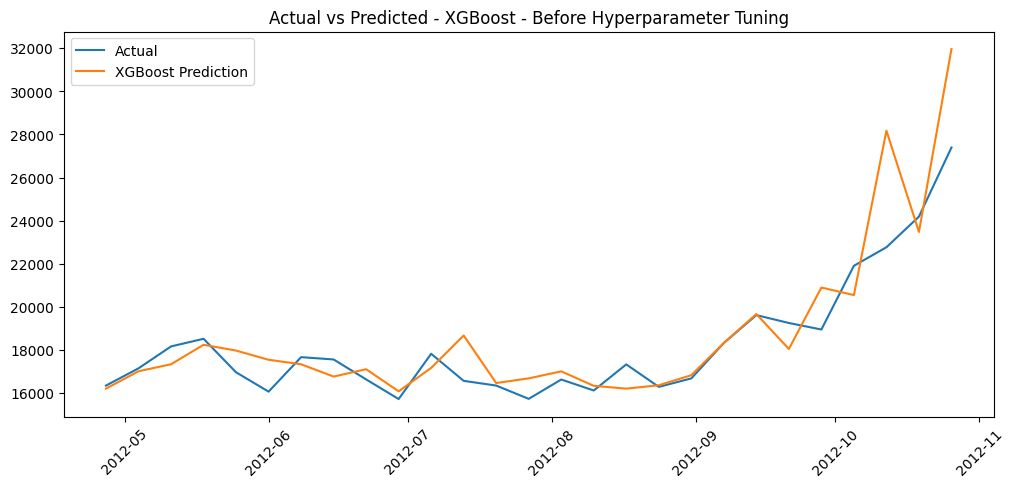

In [40]:
# XGBoost: Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], xgb_predictions, label='XGBoost Prediction')
plt.legend()
plt.title("Actual vs Predicted - XGBoost - Before Hyperparameter Tuning")
plt.xticks(rotation=45)
plt.show()

In [41]:
# Create Comparison Table
import pandas as pd

comparison_df = pd.DataFrame({
    "RMSE": [rmse_naive, rmse_lr, rmse_rf, rmse_xgb],
    "MAE": [mae_naive, mae_lr, mae_rf, mae_xgb],
    "MAPE (%)": [mape_naive, mape_lr, mape_rf, mape_xgb]
}, index=["Naive", "Linear Regression", "Random Forest", "XGBoost"])

print("Model Comparison Table:")
print(comparison_df)


Model Comparison Table:
                          RMSE          MAE  MAPE (%)
Naive              1308.695508  1077.382963  5.727465
Linear Regression  3036.934759  1455.299034  8.446822
Random Forest      1336.129447   965.992181  4.920910
XGBoost            1611.158222   994.413271  5.013698


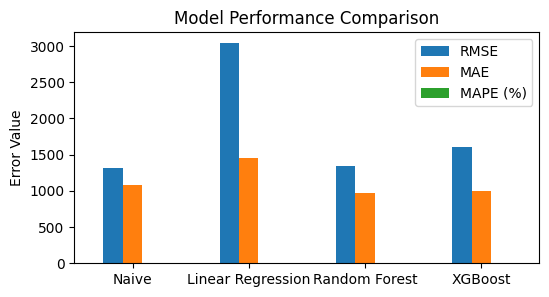

In [42]:
# Visualize Comparison
import matplotlib.pyplot as plt

comparison_df.plot(kind='bar', figsize=(6,3))
plt.title("Model Performance Comparison")
plt.xticks(rotation=0)
plt.ylabel("Error Value")
plt.show()


In [43]:
# updating the hyperparameters of xgboost to get better results

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)


In [44]:
# evaluating the new xgboost model

# Evaluate XGBoost
rmse_xgb, mae_xgb, mape_xgb = evaluate_model(
    y_test, xgb_predictions, "XGBoost"
)


XGBoost Performance:
RMSE: 1114.68
MAE: 782.05
MAPE: 4.02%


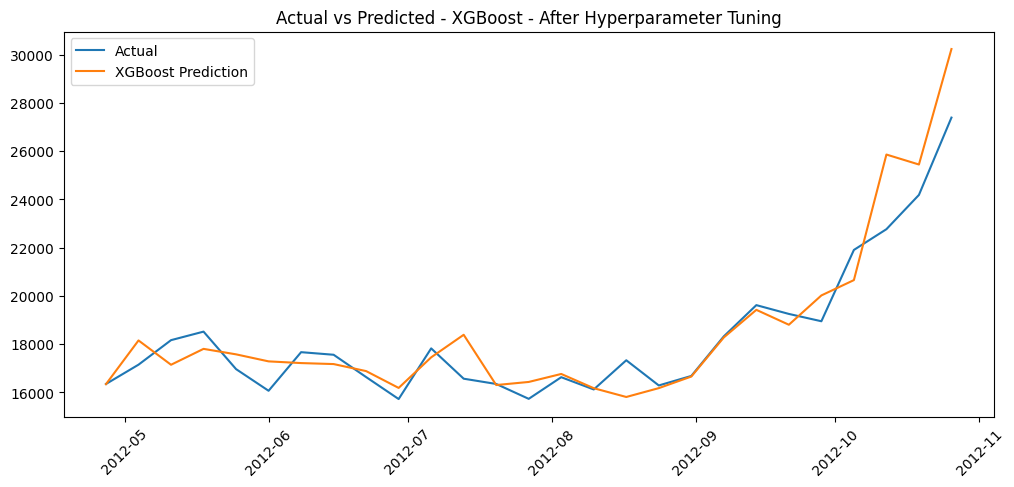

In [45]:
# XGBoost: Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], xgb_predictions, label='XGBoost Prediction')
plt.legend()
plt.title("Actual vs Predicted - XGBoost - After Hyperparameter Tuning")
plt.xticks(rotation=45)
plt.show()

In [46]:
# Comparison Table - updated with new XGBoost results
import pandas as pd

comparison_df = pd.DataFrame({
    "RMSE": [rmse_naive, rmse_lr, rmse_rf, rmse_xgb],
    "MAE": [mae_naive, mae_lr, mae_rf, mae_xgb],
    "MAPE (%)": [mape_naive, mape_lr, mape_rf, mape_xgb]
}, index=["Naive", "Linear Regression", "Random Forest", "XGBoost"])

print("Model Comparison Table after tuning XGBoost hyperparameters:")
print(comparison_df)


Model Comparison Table after tuning XGBoost hyperparameters:
                          RMSE          MAE  MAPE (%)
Naive              1308.695508  1077.382963  5.727465
Linear Regression  3036.934759  1455.299034  8.446822
Random Forest      1336.129447   965.992181  4.920910
XGBoost            1114.676667   782.053312  4.015584


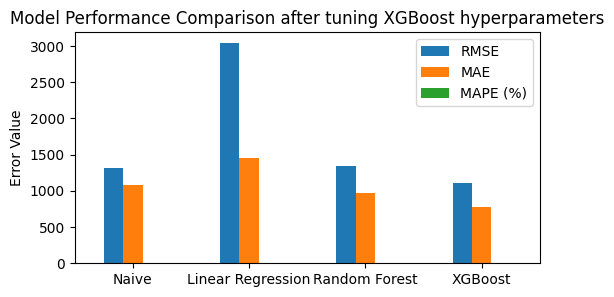

In [47]:
# Visualize Comparison - updated with new XGBoost results
import matplotlib.pyplot as plt

comparison_df.plot(kind='bar', figsize=(6,3))
plt.title("Model Performance Comparison after tuning XGBoost hyperparameters")
plt.xticks(rotation=0)
plt.ylabel("Error Value")
plt.show()


In [48]:
# insights:
# You tuned it (or changed configuration), and performance improved.

# This tells us:

# XGBoost was underfitting earlier.

# Your data does contain nonlinear structure.

# Boosting can extract more refined patterns than RF.

# This is exactly how gradient boosting works:

# It sequentially corrects errors from previous trees.

In [49]:
# 🔵 What This Means About Your Dataset

# Your data:

# Has nonlinear relationships.

# Has residual patterns RF didn’t fully capture.

# Has subtle interactions between lag features.

# XGBoost refined them.

In [50]:
# 🔵 Bigger Insight

# Your modeling progression now looks like:

# Naive → decent
# Linear → weak
# Random Forest → strong
# XGBoost (tuned) → strongest

# That is a clean modeling narrative.

In [51]:
# Import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [52]:
# Prepare the Data for SARIMA

# SARIMA needs:

# ✔ A single column series
# ✔ Indexed by date
# ✔ No extra features


# Make a copy for SARIMA
sarima_df = df_filtered[['Date', 'Weekly_Sales']].copy()

# Set date as index
sarima_df.set_index('Date', inplace=True)

# Ensure it's sorted
sarima_df = sarima_df.sort_index()


In [53]:
# Train–Test Split for SARIMA (Time-Based)

train_size = int(len(sarima_df) * 0.8)
sarima_train = sarima_df.iloc[:train_size]
sarima_test = sarima_df.iloc[train_size:]


In [54]:
# Fit SARIMA model

sarima_model = SARIMAX(
    sarima_train,
    order=(1, 1, 1),             # p, d, q
    seasonal_order=(1, 1, 1, 12), # P, D, Q, 12-week seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)


c:\Users\sayon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\sayon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [55]:
# Forecast on Test Period

sarima_predictions = sarima_result.predict(
    start=sarima_test.index[0],
    end=sarima_test.index[-1]
)


In [56]:
# Evaluate SARIMA

rmse_sarima, mae_sarima, mape_sarima = evaluate_model(
    sarima_test['Weekly_Sales'],
    sarima_predictions,
    "SARIMA"
)


SARIMA Performance:
RMSE: 14016.58
MAE: 13310.30
MAPE: 75.32%


In [57]:
# Add to comparison table

comparison_df.loc["SARIMA"] = [rmse_sarima, mae_sarima, mape_sarima]
print(comparison_df)


                           RMSE           MAE   MAPE (%)
Naive               1308.695508   1077.382963   5.727465
Linear Regression   3036.934759   1455.299034   8.446822
Random Forest       1336.129447    965.992181   4.920910
XGBoost             1114.676667    782.053312   4.015584
SARIMA             14016.583349  13310.298085  75.322614


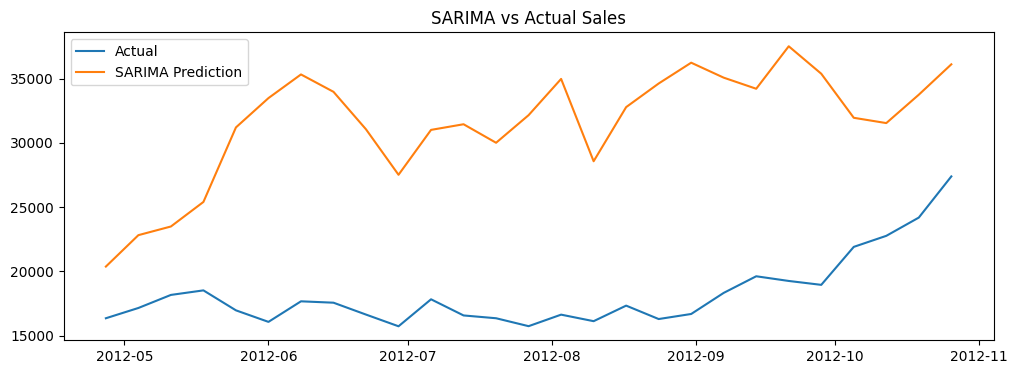

In [58]:
# Visualize

plt.figure(figsize=(12,4))
plt.plot(sarima_test.index, sarima_test['Weekly_Sales'], label="Actual")
plt.plot(sarima_test.index, sarima_predictions, label="SARIMA Prediction")
plt.title("SARIMA vs Actual Sales")
plt.legend()
plt.show()


In [59]:
# trying ARIMA to see whether it works better without seasonality

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(sarima_train, order=(2, 1, 2))
arima_result = arima_model.fit()

# Forecast
arima_predictions = arima_result.predict(
    start=sarima_test.index[0],
    end=sarima_test.index[-1]
)



c:\Users\sayon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\sayon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\sayon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\sayon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [60]:
# Evaluate ARIMA
rmse_arima, mae_arima, mape_arima = evaluate_model(
    sarima_test['Weekly_Sales'],
    arima_predictions,
    "ARIMA"
)


ARIMA Performance:
RMSE: 10455.35
MAE: 9663.91
MAPE: 55.59%


In [61]:
# Add to comparison table
comparison_df.loc["ARIMA"] = [rmse_arima, mae_arima, mape_arima]
print(comparison_df)

                           RMSE           MAE   MAPE (%)
Naive               1308.695508   1077.382963   5.727465
Linear Regression   3036.934759   1455.299034   8.446822
Random Forest       1336.129447    965.992181   4.920910
XGBoost             1114.676667    782.053312   4.015584
SARIMA             14016.583349  13310.298085  75.322614
ARIMA              10455.353664   9663.906798  55.594126


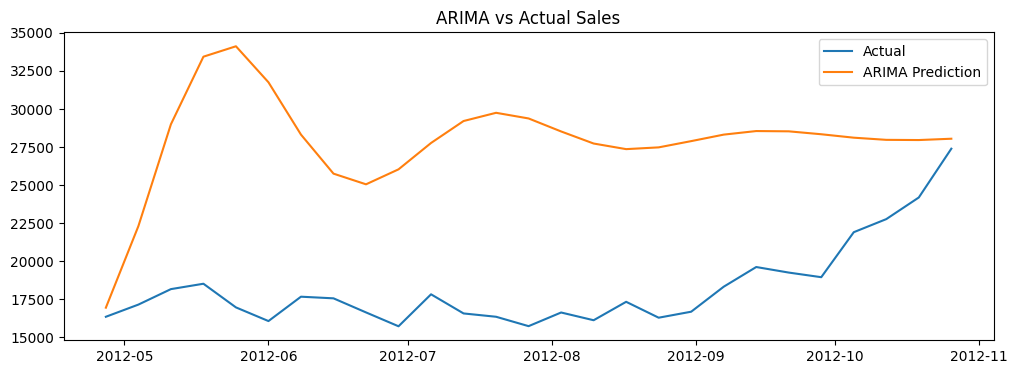

In [62]:
# Visualize

plt.figure(figsize=(12,4))
plt.plot(sarima_test.index, sarima_test['Weekly_Sales'], label="Actual")
plt.plot(sarima_test.index, arima_predictions, label="ARIMA Prediction")
plt.title("ARIMA vs Actual Sales")
plt.legend()
plt.show()


In [63]:
# XGBoost is the best model for this dataset, with the lowest RMSE, MAE, and MAPE compared to Naive, Linear Regression, Random Forest, SARIMA, and ARIMA models. This indicates that XGBoost is able to capture the complex nonlinear relationships in the data more effectively than the other models.

In [64]:
# SHAP Implementation

# Import and prepare model

import shap

# Use the trained XGBoost model (xgb_model)
explainer = shap.TreeExplainer(xgb_model)

# We use X_test because SHAP explains test predictions
shap_values = explainer.shap_values(X_test)

AttributeError: partially initialized module 'torch' has no attribute 'fx' (most likely due to a circular import)

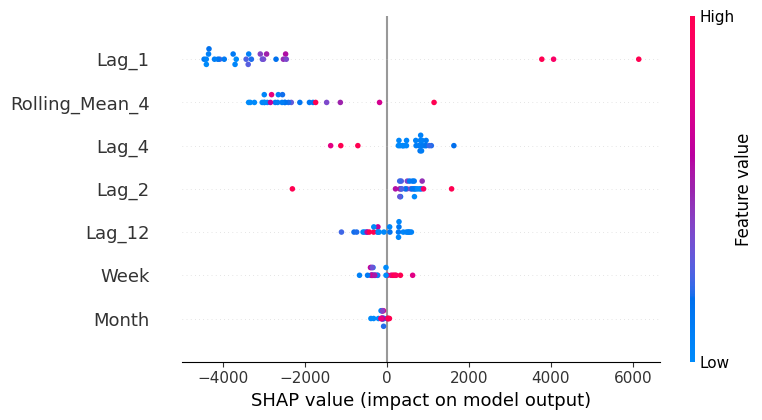

In [ ]:
# SHAP Summary Plot (Global Feature Importance)

shap.summary_plot(shap_values, X_test)

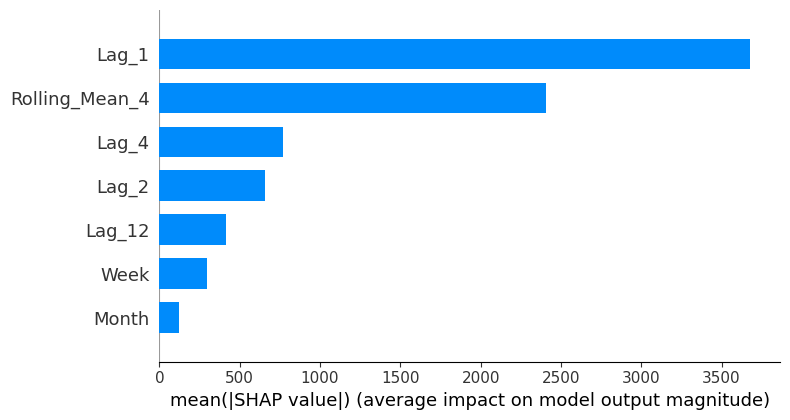

In [ ]:
# SHAP Bar Plot (Simple Global Importance)

shap.summary_plot(shap_values, X_test, plot_type="bar")

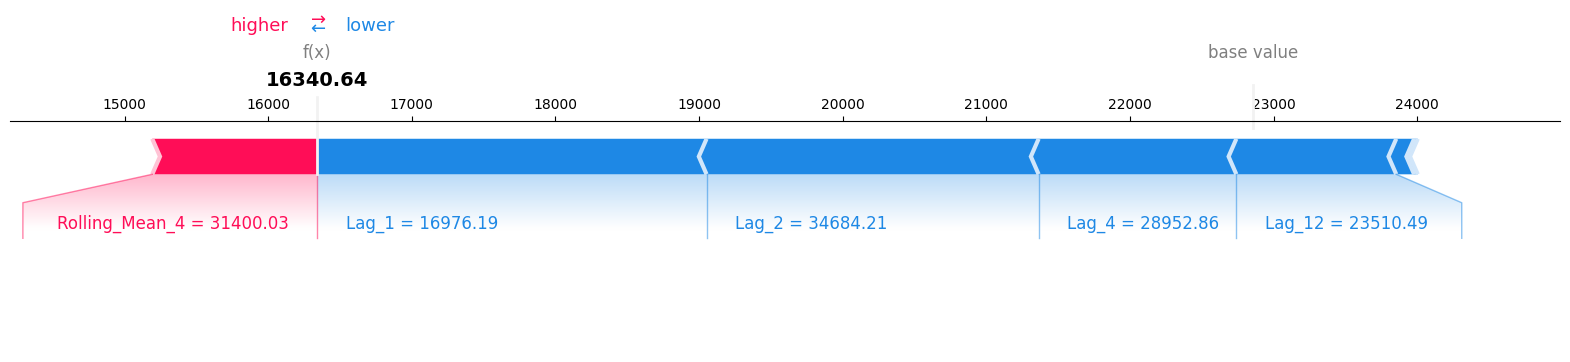

In [ ]:
# SHAP Force Plot - Decision Plot Alternative (Local Explanation)

import shap
shap.initjs()  # for JS plots

# and use matplotlib version for reliability

i = 0  # index of the first test sample
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

shap.force_plot(
    explainer.expected_value, 
    shap_values[i], 
    X_test.iloc[i],
    matplotlib=True
)